In [ ]:
! nvidia-smi

Sat Sep  2 06:04:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install timm shap grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=938be895c6a9355d73caf1c8dd0d8fdc05aa3f24a188c731e00a402748d21307
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
%pip install git+https://github.com/pytorch/captum.git

  Cloning https://github.com/pytorch/captum.git to /tmp/pip-req-build-oiy2vku4
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/captum.git /tmp/pip-req-build-oiy2vku4
  Resolved https://github.com/pytorch/captum.git to commit 945c582cc0b08885c4e2bfecb020abdfac0122f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for captum: filename=captum-0.6.0-py3-none-any.whl size=588985 sha256=69b08bf20ac04426bb83c699e6b25d4a2cb4dafd8bbf840ce9cdc49cca62aff8
  Stored in directory: /tmp/pip-ephem-wheel-cache-bmn3q6rb/wheels/8e/b7/c3/e17a61e561b99ab720ae04e56543dcd69884dee09a09bf5ae4
Successfully built captum


In [ ]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = timm.create_model("resnet18", pretrained=True)
model.eval()
model = model.to(device)

In [ ]:
# Download human-readable labels for ImageNet.
# get the classnames
url, filename = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "imagenet_classes.txt",
)
urllib.request.urlretrieve(url, filename)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


In [ ]:
list(enumerate(categories))

[(0, 'tench'),
 (1, 'goldfish'),
 (2, 'great white shark'),
 (3, 'tiger shark'),
 (4, 'hammerhead'),
 (5, 'electric ray'),
 (6, 'stingray'),
 (7, 'cock'),
 (8, 'hen'),
 (9, 'ostrich'),
 (10, 'brambling'),
 (11, 'goldfinch'),
 (12, 'house finch'),
 (13, 'junco'),
 (14, 'indigo bunting'),
 (15, 'robin'),
 (16, 'bulbul'),
 (17, 'jay'),
 (18, 'magpie'),
 (19, 'chickadee'),
 (20, 'water ouzel'),
 (21, 'kite'),
 (22, 'bald eagle'),
 (23, 'vulture'),
 (24, 'great grey owl'),
 (25, 'European fire salamander'),
 (26, 'common newt'),
 (27, 'eft'),
 (28, 'spotted salamander'),
 (29, 'axolotl'),
 (30, 'bullfrog'),
 (31, 'tree frog'),
 (32, 'tailed frog'),
 (33, 'loggerhead'),
 (34, 'leatherback turtle'),
 (35, 'mud turtle'),
 (36, 'terrapin'),
 (37, 'box turtle'),
 (38, 'banded gecko'),
 (39, 'common iguana'),
 (40, 'American chameleon'),
 (41, 'whiptail'),
 (42, 'agama'),
 (43, 'frilled lizard'),
 (44, 'alligator lizard'),
 (45, 'Gila monster'),
 (46, 'green lizard'),
 (47, 'African chameleon'),


In [ ]:
! wget -O cat.jpeg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw&usqp=CAU"

--2023-09-02 06:05:27--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw&usqp=CAU
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.200.102, 74.125.200.138, 74.125.200.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.200.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6107 (6.0K) [image/jpeg]
Saving to: ‘cat.jpeg’

cat.jpeg            100%[===================>]   5.96K  --.-KB/s    in 0s      

2023-09-02 06:05:27 (73.9 MB/s) - ‘cat.jpeg’ saved [6107/6107]



In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

transform_normalize = T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

img = Image.open('cat.jpeg')

transformed_img = transform(img)

img_tensor = transform_normalize(transformed_img)
img_tensor = img_tensor.unsqueeze(0)

In [ ]:
img_tensor = img_tensor.to(device)
with torch.no_grad():
    output = model(img_tensor)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = categories[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Egyptian cat ( 0.5664435625076294 )


In [ ]:
pred_label_idx

tensor(285, device='cuda:0')

Normal Gradients

In [ ]:
img_tensor_2 = img_tensor.clone()

In [ ]:
img_tensor_2.shape

torch.Size([1, 3, 224, 224])

In [ ]:
img_tensor_2.requires_grad = True

In [ ]:
output = model(img_tensor_2)
output = F.softmax(output, dim=1)

In [ ]:
output.shape

torch.Size([1, 1000])

In [ ]:
torch.tensor([0.0] * 284 + [1.0] + [0.0] * 715).unsqueeze(0).shape

torch.Size([1, 1000])

In [ ]:
l = (output - torch.tensor([0.0] * 284 + [1.0] + [0.0] * 715).unsqueeze(0).to(device))

In [ ]:
l = l.mean()

In [ ]:
l.backward()

In [ ]:
img_tensor_2.grad.shape

torch.Size([1, 3, 224, 224])

In [ ]:
img_tensor_2.grad.max()

tensor(4.2387e-12, device='cuda:0')

In [ ]:
img_tensor_2.grad.min()

tensor(-4.0873e-12, device='cuda:0')

In [ ]:
img_grad = torch.relu(img_tensor_2.grad[0, 0])

In [ ]:
(img_tensor_2.grad.max() - img_tensor_2.grad.min())

tensor(8.3259e-12, device='cuda:0')

In [ ]:
img_grad = (torch.relu(img_tensor_2.grad[0, 0]) - torch.relu(img_tensor_2.grad[0, 0]).min()) / (torch.relu(img_tensor_2.grad[0, 0]).max() - torch.relu(img_tensor_2.grad[0, 0]).min())

In [ ]:
img_grad.min(), img_grad.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [ ]:
img_grad.shape

torch.Size([224, 224])

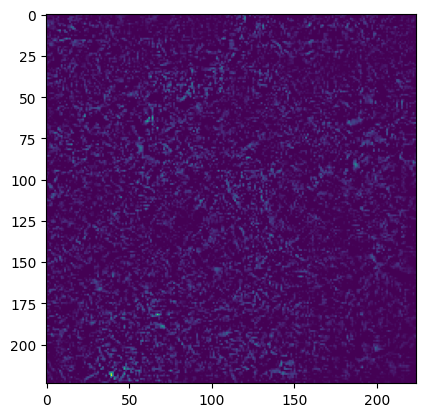

In [ ]:
plt.imshow(img_grad.cpu())

## Captum Model Interpretation

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)

Predicted: Egyptian cat ( 0.5664435625076294 )


In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (1, '#000000')], N=256)

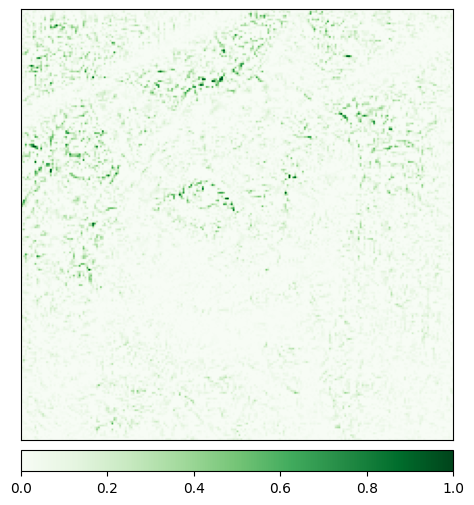

In [ ]:
attributions_ig = integrated_gradients.attribute(img_tensor, target=285, n_steps=400)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             method='heat_map',
                            #  cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

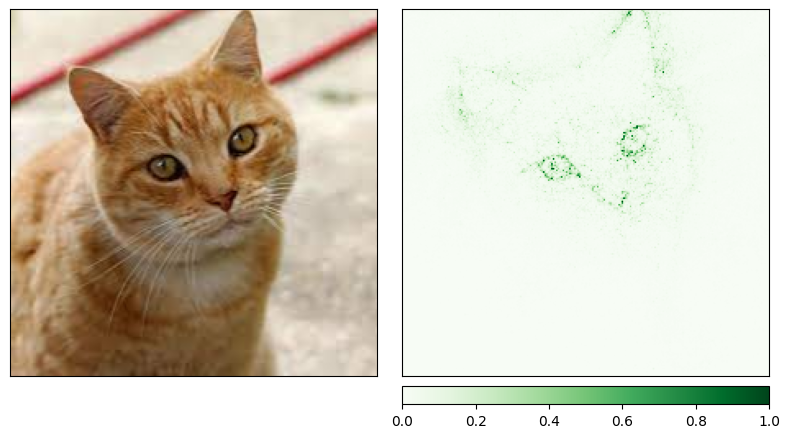

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(img_tensor, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                    #   cmap=default_cmap,
                                      show_colorbar=True)

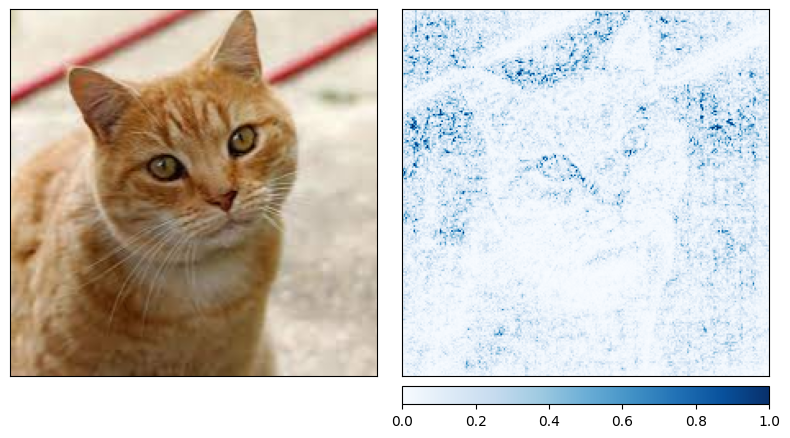

In [ ]:
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([img_tensor * 0, img_tensor * 1])

attributions_gs = gradient_shap.attribute(img_tensor,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                    #   cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img_tensor,
                                       strides = (3, 2, 2),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

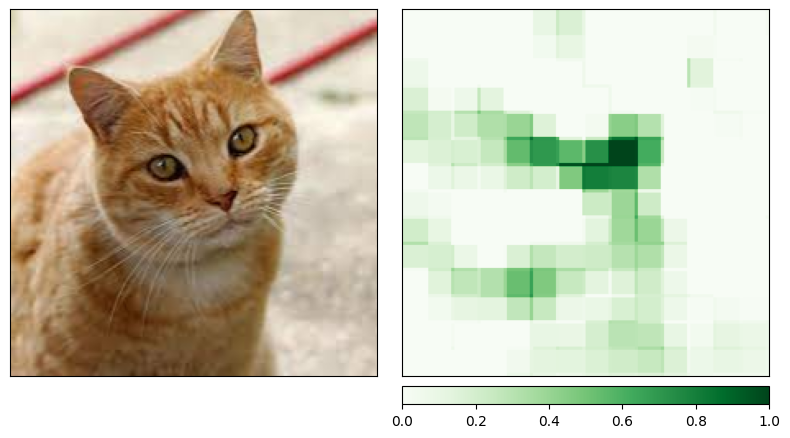

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## SHAP

Works well where number of classes are less

In [ ]:
import shap

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.to(device)

In [ ]:
model_out = model(img_tensor)
classes = torch.argmax(model_out, axis=1).cpu().numpy()
print(f'Classes: {classes}: {np.array(categories)[classes]}')

Classes: [285]: ['Egyptian cat']


In [ ]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_transform= T.Compose([
    T.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    T.Lambda(lambda x: x.permute(0, 2, 3, 1)),
])

In [ ]:
def predict(imgs: torch.Tensor) -> torch.Tensor:
    imgs = torch.tensor(imgs)
    imgs = imgs.permute(0, 3, 1, 2)

    img_tensor = imgs.to(device)

    output = model(img_tensor)
    return output

In [ ]:
topk = 10
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", (224, 224, 3))

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=categories)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
image_np = Image.open("cat.jpeg")
img_tensor = transform(image_np)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.permute(0, 2, 3, 1)

shap_values = explainer(img_tensor, max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 2it [00:44, 44.35s/it]               


In [ ]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 10))

In [ ]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]

In [ ]:
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

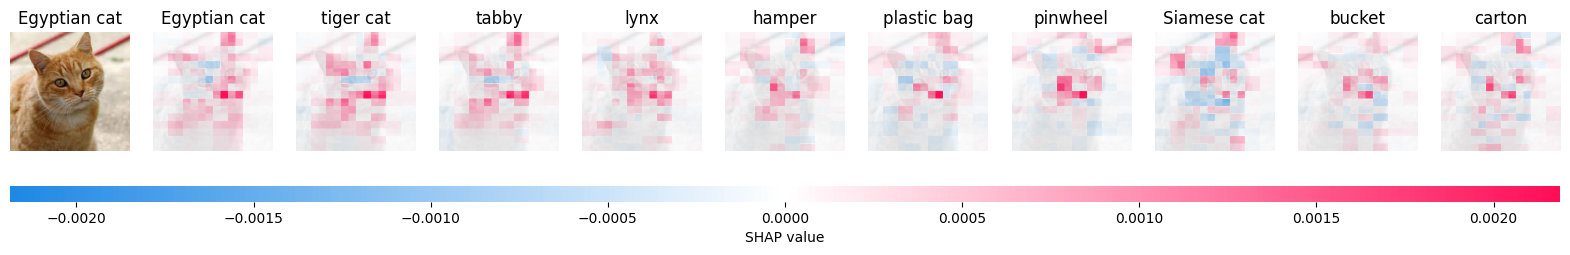

In [ ]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names,
                true_labels=[categories[285]])

## Captum Robustness

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [ ]:
img_tensor.requires_grad

True

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(img_tensor, target=285)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
original_image = np.transpose((img_tensor.squeeze(0).cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

In [ ]:
original_image.shape

(224, 224, 3)

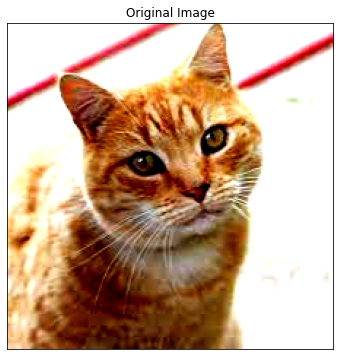

In [ ]:
_ = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

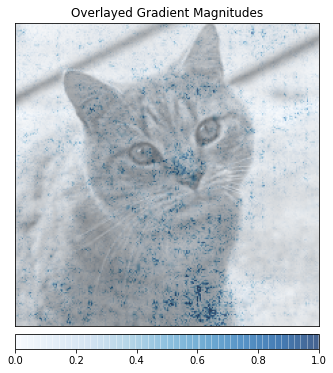

In [ ]:
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=285,
                                              **kwargs
                                             )

    return tensor_attributions


In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, img_tensor, baselines=img_tensor * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0743], device='cuda:0', dtype=torch.float64)


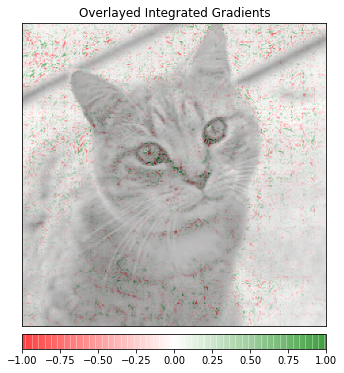

In [ ]:
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map", sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

## Captum Model Robustness

In [ ]:
from captum.robust import FGSM
from captum.robust import PGD

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_transform= T.Compose([
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
])

In [ ]:
def get_prediction(model, image: torch.Tensor):
    model = model.to(device)
    img_tensor = image.to(device)
    with torch.no_grad():
        output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]

    return predicted_label, prediction_score.squeeze().item()

    # print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

In [ ]:
# Get original prediction
pred, score  = get_prediction(model, img_tensor)

In [ ]:
def image_show(img, pred):
    npimg = inv_transform(img).squeeze().permute(1, 2, 0).detach().numpy()
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()

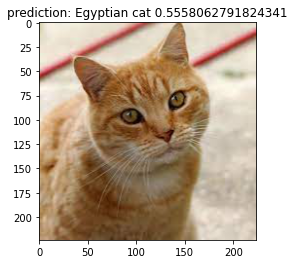

In [ ]:
image_show(img_tensor.cpu(), pred + " " + str(score))

In [ ]:
# Construct FGSM attacker
fgsm = FGSM(model, lower_bound=-1, upper_bound=1)
perturbed_image_fgsm = fgsm.perturb(img_tensor, epsilon=0.16, target=285)
new_pred_fgsm, score_fgsm = get_prediction(model, perturbed_image_fgsm)

In [ ]:
# inv_transform(img_tensor).shape

torch.Size([1, 3, 224, 224])

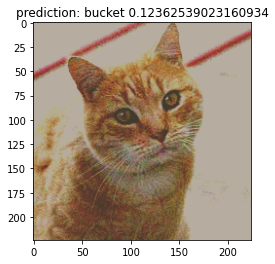

In [ ]:
image_show(perturbed_image_fgsm.cpu(), new_pred_fgsm + " " + str(score_fgsm))

In [ ]:
pgd = PGD(model, torch.nn.CrossEntropyLoss(reduction='none'), lower_bound=-1, upper_bound=1)  # construct the PGD attacker

perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02,
                                  step_num=7, target=torch.tensor([199]).to(device), targeted=True)
new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)

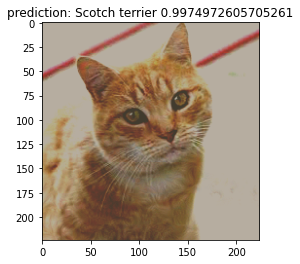

In [ ]:
image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd))

Feature Ablation

In [ ]:
feature_mask = torch.arange(64 *7*7).reshape(8*7, 8*7).repeat_interleave(repeats=4, dim=1).repeat_interleave(repeats=4, dim=0).reshape(1, 1, 224,224)
print(feature_mask)

tensor([[[[   0,    0,    0,  ...,   55,   55,   55],
          [   0,    0,    0,  ...,   55,   55,   55],
          [   0,    0,    0,  ...,   55,   55,   55],
          ...,
          [3080, 3080, 3080,  ..., 3135, 3135, 3135],
          [3080, 3080, 3080,  ..., 3135, 3135, 3135],
          [3080, 3080, 3080,  ..., 3135, 3135, 3135]]]])


In [ ]:
feature_mask.shape

torch.Size([1, 1, 224, 224])

In [ ]:
from captum.attr import FeatureAblation

ablator = FeatureAblation(model)
attr = ablator.attribute(img_tensor, target=285, feature_mask=feature_mask)
# Choose single channel, all channels have same attribution scores
pixel_attr = attr[:,0:1]

In [ ]:
def pixel_dropout(image, dropout_pixels):
    keep_pixels = image[0][0].numel() - int(dropout_pixels)
    vals, _ = torch.kthvalue(pixel_attr.flatten(), keep_pixels)
    return (pixel_attr < vals.item()) * image

In [ ]:
from captum.robust import MinParamPerturbation

min_pert_attr = MinParamPerturbation(forward_func=model, attack=pixel_dropout, arg_name="dropout_pixels", mode="linear",
                                     arg_min=0, arg_max=1024, arg_step=16,
                                     preproc_fn=None, apply_before_preproc=True)

In [ ]:
pixel_dropout_im, pixels_dropped = min_pert_attr.evaluate(img_tensor, target=285, perturbations_per_eval=10)
print("Minimum Pixels Dropped:", pixels_dropped)

Minimum Pixels Dropped: 480


In [ ]:
new_pred_dropout, score_dropout = get_prediction(model, pixel_dropout_im)

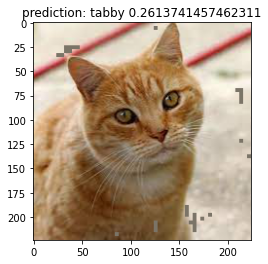

In [ ]:
image_show(pixel_dropout_im.cpu(), new_pred_dropout + " " + str(score_dropout))

# Grad CAM

In [ ]:
import timm
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
device = torch.device("cpu")

In [ ]:
model = timm.create_model("resnet18", pretrained=True)
model.eval()
model = model.to(device)

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_transform = T.Compose([
    # T.Lambda(lambda x: x.permute(0, 2, 3, 1)),
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    # T.Lambda(lambda x: x.permute(0, 3, 1, 2)),
])

In [ ]:
target_layers = [model.layer4[-1]]

In [ ]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
targets = [ClassifierOutputTarget(285)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)

In [ ]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
grayscale_cam.shape

(224, 224)

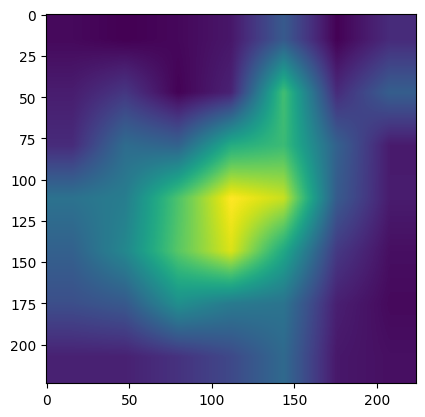

In [ ]:
plt.imshow(grayscale_cam)

In [ ]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
rgb_img = inv_transform(img_tensor).cpu().squeeze().permute(1, 2, 0).detach().numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

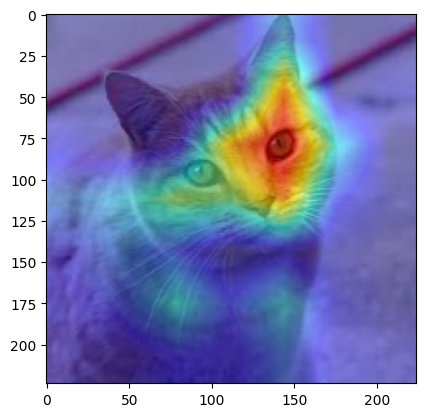

In [ ]:
plt.imshow(visualization)

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus

In [ ]:
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)

In [ ]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
rgb_img = inv_transform(img_tensor).cpu().squeeze().permute(1, 2, 0).detach().numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

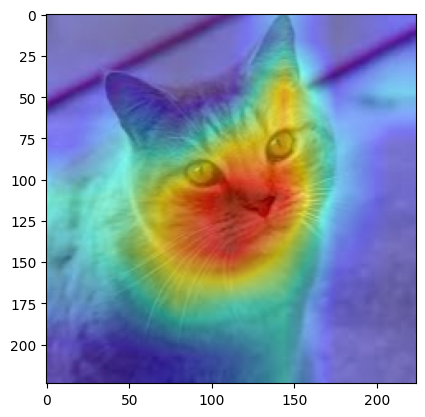

In [ ]:
plt.imshow(visualization)